# Imports

In [1]:
import numpy as np
import itertools
from typing import List, Dict
import time
import ast
import pandas
import matplotlib.pylab as plt
import random

In [2]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [3]:
def score_function(seq1, seq2, gap, match, mismatch):
    score = 0
    for x, y in zip(seq1, seq2):
        if x == y:
            score += match
        elif x == '-' or y == '-':
            score += gap
        else:
            score += mismatch
    return score

# First Algo

In [4]:
def update(grid, i, j, ismatch, gap, match, mismatch):
    left = grid[i, j - 1] + gap
    up = grid[i - 1, j] + gap
    dig = grid[i - 1, j - 1] + match if ismatch else grid[i - 1, j - 1] + mismatch
    grid[i, j] = max(left, up, dig)

In [5]:
def init(grid, i, j, gap):
    if i == 0 and j == 0:
        grid[i, j] = 0
    elif i == 0:
        grid[i, j] = grid[i, j-1] + gap
    elif j == 0:
        grid[i, j] = grid[i-1, j] + gap
    else:
        raise("error")

In [6]:
def nw(x, y, debug, gap=-2, match=1, mismatch=-1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [7]:
def algorithm1(seq1, seq2, debug, gap=-2, match=1, mismatch=-1):
    number_of_comp = 0
    if len(seq1) < len(seq2):
        temp = seq1
        seq1 = seq2
        seq2 = temp
    grid = np.zeros(
        (len(seq1)+1, len(seq2)+1)
    )
    if debug:
        print(grid)
        print(grid.shape)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            number_of_comp += 1
            if i == 0 or j == 0:
                init(grid, i, j, gap)
            else:
                ismatch = seq1[i-1] == seq2[j-1]
                update(grid, i, j, ismatch, gap, match, mismatch)
    if debug:
        print(grid)
        print(i, j)
    result1 = ""
    result2 = ""
    while i > 0 and j > 0:
        ismatch = seq1[i-1] == seq2[j-1]
        number_of_comp += 1
        if ismatch:
            i -= 1
            j -= 1
            result1 += seq1[i]
            result2 += seq2[j]
            if debug:
                print(result1[::-1])
                print(result2[::-1])
        else:
            left = grid[i, j - 1]
            up = grid[i - 1, j]
            dig = grid[i - 1, j - 1]
            values = [left, up, dig]
            max_value = max(values)
            for idx, value in enumerate(values):
                number_of_comp += 1
                if value == max_value:
                    if idx == 0:
                        number_of_comp += 1
                        j -= 1
                        result1 += "-"
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    elif idx ==1:
                        number_of_comp += 2
                        i -= 1
                        result1 += seq1[i]
                        result2 += "-"
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    else:
                        number_of_comp += 2
                        i -= 1
                        j -= 1
                        result1 += seq1[i]
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
    if i == 1:
        number_of_comp += 1
        i -= 1
        result1 += seq1[i]
        result2 += "-"
    elif j == 1:
        number_of_comp += 2
        j -= 1
        result1 += "-"
        result2 += seq2[j]
    if debug:
        print(i, j, grid[i,j])
        print(result1[::-1])
        print(result2[::-1])
    
    return result1[::-1], result2[::-1], number_of_comp         

In [8]:
seq1 = "Mohammed"
seq2 = "hamed"

In [9]:
seq2 = "ATGCT"
seq1 = "AGCT"

In [10]:
seq1 = "DISTANCE"
seq2 = "EDIT"

In [11]:
algorithm1(seq2, seq1, debug=False)

('-DISTANCE', 'EDI-T----', 80)

# Analysis

In [21]:
def analysis(algo, data, hyperparameters_list: List[Dict[str, int]], debug: bool):
    plt.figure(figsize=(20,10))
    """
    Args:
        algorithm: function that accept two string sequences, a debug boolean, and hyperparameters dict
        sequences: list of strings, each string is a sequence that is going to be aligned against every other sequence
        hyperparameters_list: list of hyperparameters dicts
        debug: bool that decided wether or not to print debugging logs
    Returns:
        Dataframe of all the experiment results, and plots standrized theortical time complexity and real runtime.
    """
    results = []

    for data_point in data:
        seq1, seq2 = data_point
        n = len(seq1)
        m = len(seq2)
        outputs, runtimes, num_comp, edit_distances, scores  = [], [], [], [], []
        for i, hyperparameters in enumerate(hyperparameters_list):
            total_times = []
            for _ in range(5):
                start_time = time.time()
                output = algo(seq1, seq2, debug=debug, **hyperparameters)
                total_time = time.time() - start_time
                total_times.append(total_time)
            outputs.append(output[:2])
            num_comp.append(output[2])
            runtimes.append(np.mean(total_times))
            edit_distances.append(levenshteinDistance(*output[:2]))
            scores.append(score_function(*output[:2], **hyperparameters))
        r = {
            "outputs":outputs, "runtime":np.mean(runtimes),
            "number of comparsion": np.mean(num_comp),
            "edit distance": edit_distances,
            "score": scores,
            "input size": n*m,
            "input_size": f"{n}, {m}",
            "Avg O(m+n)" : m+n,
            "Worst O(nm)": n*m,
#             "parameter": hyperparameters_list
        }
        results.append(r)
    df = pandas.DataFrame(data=results, index=data)
    df_x = df[['runtime', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion']]

    #standardize the values for each predictor variable
    df[['runtime', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion']] = ((df_x-df_x.mean())/df_x.std()) + 2
#     df[['runtime', 'O(nm)']] = (df_x - df_x.min()) / (df_x.max() - df_x.min())
    x = df['input size']
    y1 = df['runtime']
    y2 = df['number of comparsion']
    y3 = df['Worst O(nm)']
    y4 = df['Avg O(m+n)']
    
    plt.plot(x, y1, '.b')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y1, 1))(np.unique(x)), '-b')
    
    plt.plot(x, y2, '.r')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '-r')
    
    plt.plot(x, y3, '.g')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y3, 1))(np.unique(x)), '-g')
    
    plt.plot(x, y4, '.m')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y4, 1))(np.unique(x)), '-m')    
    
    plt.xlabel('input size', fontsize=18)
    plt.ylabel('normalized values', fontsize=18)
    plt.legend(['runtime', 'runtime',  'number of comparsion', 'number of comparsion', 'Worst O(nm)', 'Worst O(nm)', 'Avg O(m+n)', 'Avg O(m+n)'], loc='upper left')
    return df

In [59]:
def analysis2(algo1, algo2, data, hyperparameters_list: List[Dict[str, int]], debug: bool):
    plt.figure(figsize=(20,10))
    """
    Args:
        algorithm: function that accept two string sequences, a debug boolean, and hyperparameters dict
        sequences: list of strings, each string is a sequence that is going to be aligned against every other sequence
        hyperparameters_list: list of hyperparameters dicts
        debug: bool that decided wether or not to print debugging logs
    Returns:
        Dataframe of all the experiment results, and plots standrized theortical time complexity and real runtime.
    """
    results = []

    for data_point in data:
        seq1, seq2 = data_point
        n = len(seq1)
        m = len(seq2)
        outputs1, outputs2, runtimes1, runtimes2, num_comp1, num_comp2, edit_distances1, scores1, edit_distances2, scores2  = [], [], [], [], [], [], [], [], [], []
        for i, hyperparameters in enumerate(hyperparameters_list):
            total_times = []
            for _ in range(5):
                start_time = time.time()
                output = algo1(seq1, seq2, debug=debug, **hyperparameters)
                total_time = time.time() - start_time
                total_times.append(total_time)
            outputs1.append(output[:2])
            num_comp1.append(output[2])
            runtimes1.append(np.mean(total_times))
            edit_distances1.append(levenshteinDistance(*output[:2]))
            scores1.append(score_function(*output[:2], **hyperparameters))
            for _ in range(5):
                start_time = time.time()
                output = algo2(seq1, seq2, debug=debug, **hyperparameters)
                total_time = time.time() - start_time
                total_times.append(total_time)
            outputs2.append(output[:2])
            num_comp2.append(output[2])
            runtimes2.append(np.mean(total_times))
            edit_distances2.append(levenshteinDistance(*output[:2]))
            scores2.append(score_function(*output[:2], **hyperparameters))
        r = {
            "outputs1":outputs1, "runtime1":np.mean(runtimes1),
            "outputs2":outputs2, "runtime2":np.mean(runtimes2),
            "number of comparsion1": np.mean(num_comp1),
            "number of comparsion2": np.mean(num_comp2),
            "edit distance1": edit_distances1,
            "edit distance2": edit_distances2,
            "score1": scores1,
            "score2": scores2,
            "input size": n*m,
            "input_size": f"{n}, {m}",
            "Avg O(m+n)" : m+n,
            "Worst O(nm)": n*m,
#             "parameter": hyperparameters_list
        }
        results.append(r)
    df = pandas.DataFrame(data=results, index=data)
    df_x = df[['runtime1', 'runtime2', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion1', 'number of comparsion2']]

    #standardize the values for each predictor variable
    df[['runtime1', 'runtime2', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion1', 'number of comparsion2']] = ((df_x-df_x.mean())/df_x.std()) + 2
#     df[['runtime', 'O(nm)']] = (df_x - df_x.min()) / (df_x.max() - df_x.min())
    x = df['input size']
    y11 = df['runtime1']
    y12 = df['runtime2']
    y21 = df['number of comparsion1']
    y22 = df['number of comparsion2']
    y3 = df['Worst O(nm)']
    y4 = df['Avg O(m+n)']
    
    plt.plot(x, y11, '.b')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y11, 1))(np.unique(x)), '-b') #runtime1
    
    plt.plot(x, y12, '.c')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y12, 1))(np.unique(x)), '-c') #runtime2
    
    plt.plot(x, y21, '.r')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y21, 1))(np.unique(x)), '-r') #comp1
    
    plt.plot(x, y22, '.y')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y22, 1))(np.unique(x)), '-y') #comp2
    
#     plt.plot(x, y3, '.g')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y3, 1))(np.unique(x)), '-g')
    
#     plt.plot(x, y4, '.m')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y4, 1))(np.unique(x)), '-m')    
    
    plt.xlabel('input size', fontsize=18)
    plt.ylabel('normalized values', fontsize=18)
    plt.legend(['runtime of algo1', 'runtime of algo1', 'runtime of algo2', 'runtime of algo2', 'number of comparsion of algo1', 'number of comparsion of algo1', 'number of comparsion of algo2', 'number of comparsion of algo2', 'O(nm)',
                # 'Worst O(nm)', 'Avg O(m+n)',
                'O(m+n)'], loc='upper left')
    return df

### Fake Data for testing

In [60]:
fake_data = [''.join(random.choice(['A', 'G', 'C', 'T']) for _ in range(random.randint(5, 10))) for _ in range(5)]

In [61]:
data = list(itertools.combinations(fake_data, r=2))

In [62]:
fake_data[:4], data[:4]

(['CCAGGGA', 'TCAACGA', 'ACTCT', 'ACTAGTACG'],
 [('CCAGGGA', 'TCAACGA'),
  ('CCAGGGA', 'ACTCT'),
  ('CCAGGGA', 'ACTAGTACG'),
  ('CCAGGGA', 'TGAAATCGG')])

### Combined algos experiment

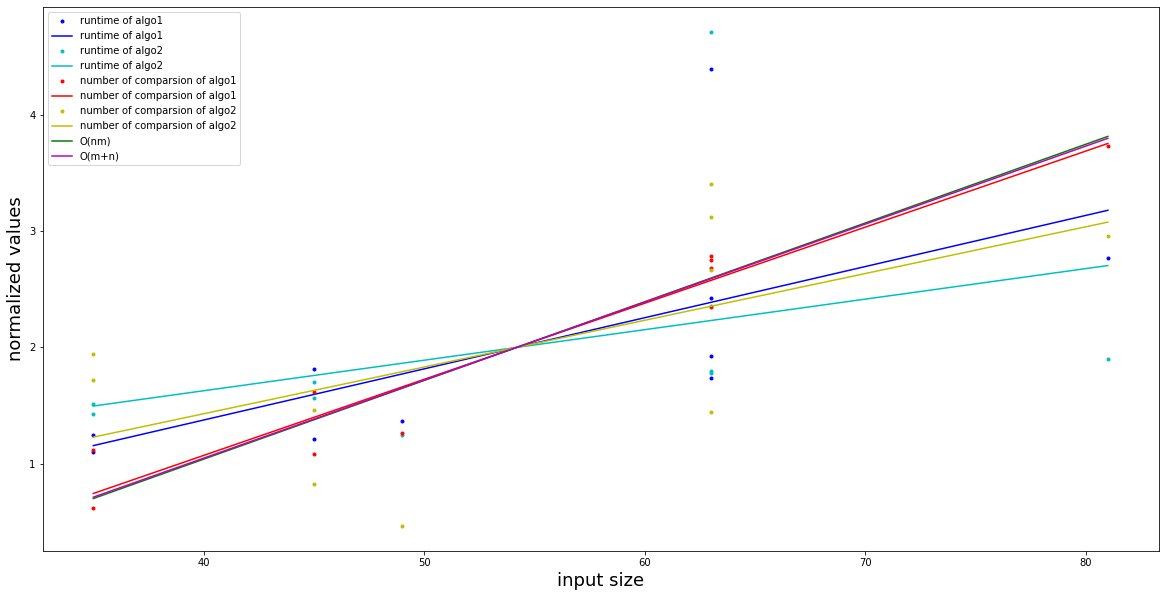

In [63]:
results_comb = analysis2(
    algo1=algorithm1, algo2=algorithm2,
    data=data,
    hyperparameters_list=hyperparameters_list, debug=False
)

### Experiment using the first algorithm

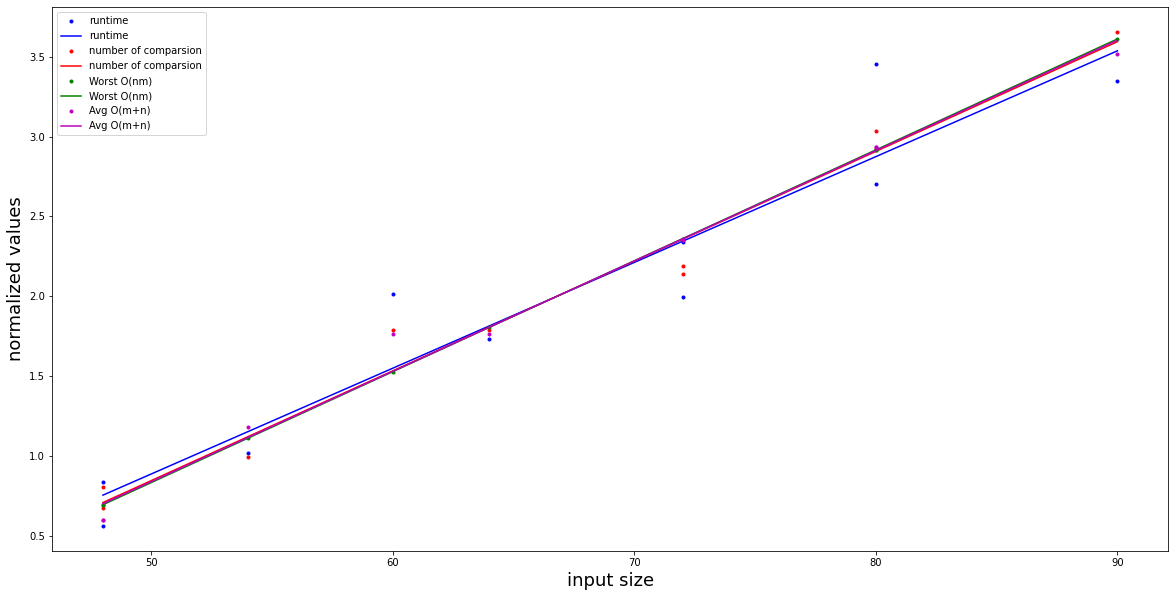

In [25]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results1 = analysis(
    algo=algorithm1,
    data=data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [26]:
from algo2 import FOGSAA as algorithm2

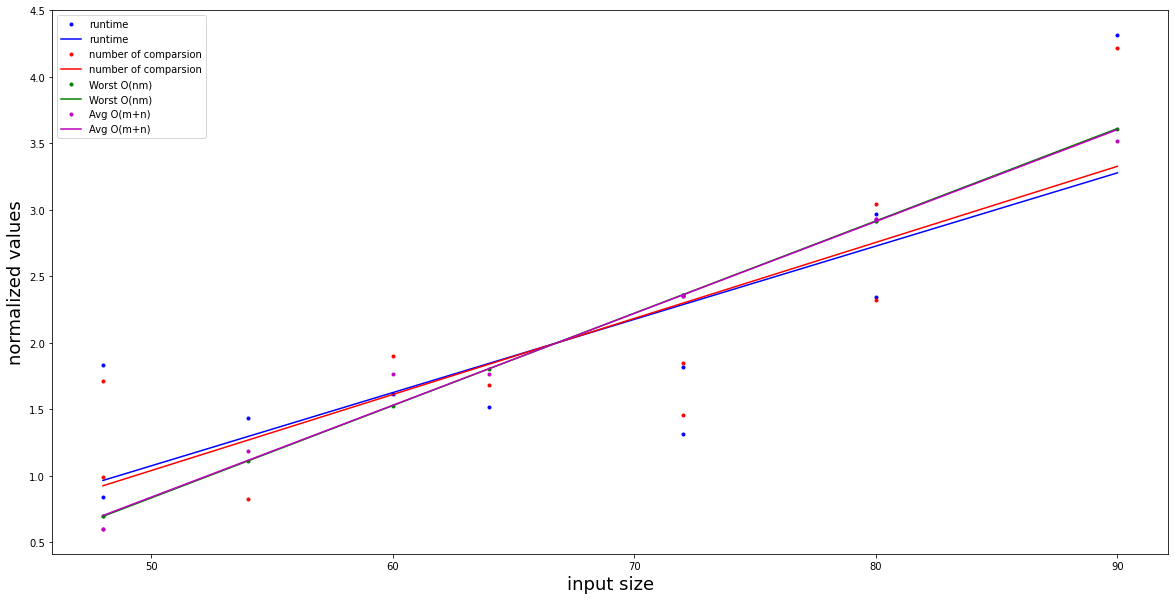

In [27]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results2 = analysis(
    algo=algorithm2,
    data=data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [17]:
results1[:10]

,outputs,runtime,number of comparsion,edit distance,score,input size,input_size,Avg O(m+n),Worst O(nm)
"(CGTACA, GGTAGAGAGG)","[(GGTAGAGAGG, CGTAC--A--), (GGTAGAGAGG, CGT--A...",1.822608,2.097433,"[6, 6, 6]","[-6, -4, -2]",60,"6, 10",2.000000,1.872784
"(CGTACA, AGATGCGCTT)","[(AGATGCGCTT, CG-TACA---), (GC-G-CT-T, C-G-TA-...",2.003088,2.151562,"[7, 5, 7]","[-8, -12, -4]",60,"6, 10",2.000000,1.872784
"(CGTACA, TCGCC)","[(-CGTACA, TCGC-C-), (-CGTACA, TCG--CC), (-CGT...",0.515013,0.419421,"[4, 4, 4]","[-4, -2, -1]",30,"6, 5",0.153628,0.556761
"(CGTACA, ATCTTATAT)","[(CTTATAT, CGTACA-), (CTTATAT, CGTACA-), (CTTA...",1.452467,1.328795,"[3, 3, 3]","[0, -1, 1]",54,"6, 9",1.630726,1.609580
"(GGTAGAGAGG, AGATGCGCTT)","[(GGTA-GAGAGG, AGA-TGCGCTT), (AGA-GAG--G, AGAT...",3.043614,3.374887,"[7, 5, 5]","[-7, -2, 0]",100,"10, 10",3.477098,3.627482
"(GGTAGAGAGG, TCGCC)","[(TAGAGAGG, TCGCC---), (TAGAGAGG, T--CG-CC), (...",1.534465,1.631920,"[6, 6, 6]","[-7, -7, -4]",50,"10, 5",1.630726,1.434110
"(GGTAGAGAGG, ATCTTATAT)","[(GGT-AG-AGAGG, A-TCT-TATAT-), (GGT-AGAGAGG, -...",3.659750,3.342409,"[9, 8, 9]","[-11, -10, -6]",90,"10, 9",3.107823,3.188807
"(AGATGCGCTT, TCGCC)","[(TGCGCTT, T-CGCC-), (TGCGCTT, T-CGC-C), (TGCG...",1.483973,1.155581,"[3, 3, 3]","[-1, 0, 1]",50,"10, 5",1.630726,1.434110
"(AGATGCGCTT, ATCTTATAT)","[(AGATGCGCTT, ATCTTATA-T), (ATGC-GCT-T, AT-CTT...",3.247254,3.071762,"[7, 5, 5]","[-5, -2, 0]",90,"10, 9",3.107823,3.188807
"(TCGCC, ATCTTATAT)","[(ATCTTATAT, -TCGCC---), (ATCTTATAT, -TC---GCC...",1.237769,1.426228,"[7, 7, 7]","[-9, -8, -5]",45,"5, 9",1.261451,1.214773


### Read Real Data (TODO)

In [28]:
# 
sequences = []
with open('sequences.txt') as f:
    lines = f.read()
for ind, prot in enumerate(lines.split(">")):
    raw = prot.split("\n")
    header = raw[0]
    seq = "".join(raw[1:])
    if len(seq) > 0:
        sequences.append(seq)
#         print(seq)
    
with open('Wuhan_genome.txt') as f:
    lines = f.read()
    genome = "".join(lines.split("\n")[1:])


In [32]:
for i in sequences:
    print(len(i))
print(len(genome))

21291
13218
3822
828
228
669
186
366
132
366
1260
117
29903


In [33]:
real_data = [(genome, s) for s in sequences[3:6]]

In [65]:
algorithm2(genome, sequences[6], debug=False)

('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTT

In [34]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results = analysis(
    algo=algorithm1,
    data=real_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [ ]:
results[:10]

In [30]:
results2[:10]

,outputs,runtime,number of comparsion,edit distance,score,input size,input_size,Avg O(m+n),Worst O(nm)
"(AGAGTGGTTGCTAGGCCTATACATGT, CTACGAGGTACTAAAAGCTCGGATACCGG)","[(----AGAGTGGTTGCTAGGCCTATACATGT, CTACGAGGTACT...",3.161918,2.709913,"[18, 17, 16]","[-17, -25, -8]",754,"26, 29",3.399684,3.448571
"(AGAGTGGTTGCTAGGCCTATACATGT, TGGCTAGTAGAACTAGTCGGCGGC)","[(AGAGTGGTTGCTAGGCCTA-T-ACATGT, ---TGGCTAG-TAG...",2.805357,2.871961,"[16, 18, 16]","[-12, -29, -4]",624,"26, 24",2.079227,2.072746
"(AGAGTGGTTGCTAGGCCTATACATGT, CAGCTTCCGAGAAACCACCACGCTGTTA)","[(AGAGTGGTTGCTAG-GCCTA-TAC-ATGT--, --CAG-CTTCC...",3.434271,3.402773,"[18, 24, 20]","[-15, -24, -9]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TTTTCGAGAAGTCCCGAAGAGAACTAAT)","[(----AGAGTGGTTGCTAGGCCTATACATGT, TTTTCGAGAAGT...",2.804205,2.805999,"[18, 26, 22]","[-12, -27, -11]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, ACCCTAGATACACCTCTTAGAG)","[(AGAGTGGTTGCTAGGCCTATACATGT, ACCCTAGATAC-ACCT...",2.372550,2.172349,"[14, 18, 14]","[-6, -18, -1]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TAGCAGAATGAGCATCACCAGCCCAG)","[(--AGAGTGGTTGCTAGGCCTATACATGT, TAGCAGAATGAGC-...",2.992142,2.894814,"[18, 20, 20]","[-14, -25, -11]",676,"26, 26",2.607410,2.623076
"(AGAGTGGTTGCTAGGCCTATACATGT, CCCAGTTGCGAAACTAAGAGCAAGGCTT)","[(---AGA-GTGGTTGCTAGGCCTATACATGT, CCCAGTTGCGAA...",2.447493,2.447104,"[18, 20, 18]","[-14, -27, -7]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TCATCGAGAAGGCTGTCACCTAA)","[(AGAGTGGTTGCTAGGCCTAT-ACATGT, TCA-TCG--A-GAAG...",1.645250,1.537659,"[16, 20, 16]","[-10, -19, -5]",598,"26, 23",1.815136,1.797581
"(AGAGTGGTTGCTAGGCCTATACATGT, TCAAGAATGCTCTTCTACCCAT)","[(AGAGTGGTTGCTAGGCCTATACATGT, TCA-AGAATGCT---C...",0.966492,0.835450,"[14, 16, 17]","[-6, -3, -9]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TCGCATACATGCGCTACGGAAGAGT)","[(-AGAGTGGTTGCTAGGCCTATACATGT, TCGCATACATGCGCT...",1.704379,1.647250,"[16, 21, 20]","[-8, -24, -14]",650,"26, 25",2.343319,2.347911


### Experiment using the second algoritm (TODO)